## Семинар 6 "Segmentation"

ФИО: Смирнов Егор Геннадьевич

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install imagecodecs 

     |████████████████████████████████| 24.7MB 1.3MB/s 


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
import skimage.transform
import gdal
import torch
import imagecodecs
import tifffile as tiff 
import imageio
from IPython.display import clear_output


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [4]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data

test = process('/content/drive/MyDrive/test/images/')
t.save(test, TEST_PATH)
train_data = process('/content/drive/MyDrive/training/images', "/content/drive/MyDrive/training/1st_manual/")

In [5]:
import PIL
class Dataset():
    def __init__(self, data, source_transform, target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((480,480)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((480,480),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data, s_trans, t_trans)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


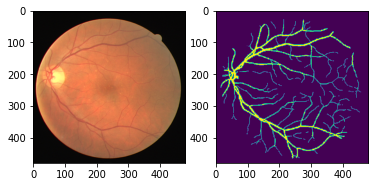

In [6]:
img,mask = dataset[0]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [7]:
img.shape

torch.Size([3, 480, 480])

In [8]:
X_train = [dataset[i] for i in range (0, 20)]

In [9]:
len(X_train)

20

## Нужна аугментация по-любому

In [21]:
X_train = []

In [22]:
for data in dataset:
  X_train.append(data)
  img, mask = data
  X_train.append((tsf.functional.rotate(img, 45), tsf.functional.rotate(mask, 45)))
  X_train.append((tsf.functional.rotate(img, 90), tsf.functional.rotate(mask, 90)))
  X_train.append((tsf.functional.rotate(img, 135), tsf.functional.rotate(mask, 135)))
  X_train.append((tsf.functional.rotate(img, 180), tsf.functional.rotate(mask, 180)))
  X_train.append((tsf.functional.rotate(img, 225), tsf.functional.rotate(mask, 225)))
  X_train.append((tsf.functional.rotate(img, 270), tsf.functional.rotate(mask, 270)))
  X_train.append((tsf.functional.rotate(img, 315), tsf.functional.rotate(mask, 315)))
  X_train.append((tsf.functional.vflip(img), tsf.functional.vflip(mask)))
  X_train.append((tsf.functional.hflip(img), tsf.functional.hflip(mask)))

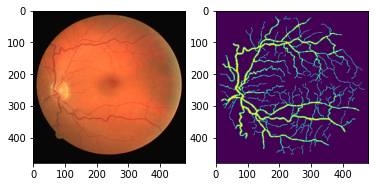

In [23]:
img,mask = X_train[14]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

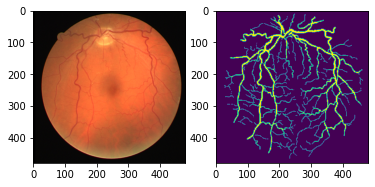

In [24]:
img,mask = X_train[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

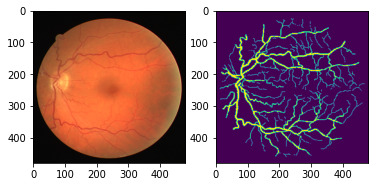

In [25]:
img,mask = X_train[19]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [26]:
len(X_train)

200

In [27]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [28]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [29]:
model = UNet(3, 1).to('cuda')

In [30]:
dataloader = t.utils.data.DataLoader(X_train, num_workers=2, batch_size=4, shuffle=True)

In [31]:
def _epoch(network, loss, loader, optimizer, device='cpu'):
    losses = []
    for X, y in loader:
        X = X.type(dtype=t.FloatTensor)
        X = X.to(device)
        y = y.to(device)
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    return losses

def train(network, train_loader, epochs, learning_rate, loss, device='cpu'):
    optimizer = t.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    network = network.to(device)
    network = network.train()
    try:
        for epoch in tqdm(range(epochs)):
            losses = _epoch(network, loss, train_loader, optimizer, device)
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('Epoch {0}... Loss: {1:.3f}'.format(
                        epoch, train_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs

In [32]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset, batch_size=1)

Epoch 79... Loss: 0.168


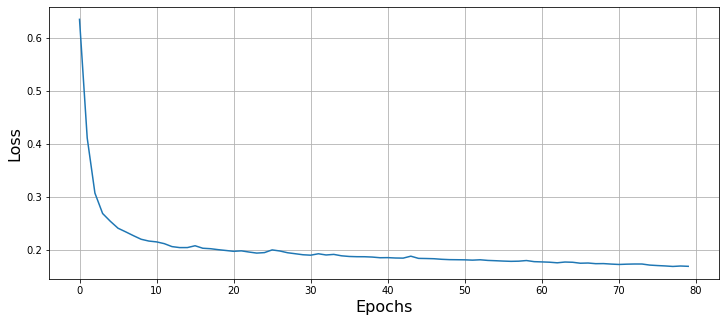

100%|██████████| 80/80 [42:17<00:00, 31.72s/it]


[0.6345757043361664,
 0.4105562222003937,
 0.3065903413295746,
 0.26805390119552613,
 0.25336893439292907,
 0.24027218222618102,
 0.23338212490081786,
 0.22621153831481933,
 0.2194300425052643,
 0.21605666995048523,
 0.21447701811790465,
 0.2111688470840454,
 0.20559338092803955,
 0.203712397813797,
 0.20375145912170411,
 0.20717990040779113,
 0.2024887228012085,
 0.20162090301513672,
 0.19980290174484253,
 0.19826281309127808,
 0.19668723702430724,
 0.1975675094127655,
 0.19532450914382934,
 0.19334403157234192,
 0.19424532175064088,
 0.19935869455337524,
 0.1972891128063202,
 0.1940084958076477,
 0.19212250232696534,
 0.19020814418792725,
 0.18937487602233888,
 0.1920594370365143,
 0.18977269530296326,
 0.190872905254364,
 0.1882130193710327,
 0.1869601333141327,
 0.1865170681476593,
 0.1864612877368927,
 0.1858320426940918,
 0.1845748782157898,
 0.18477185368537902,
 0.18407187938690187,
 0.1838330864906311,
 0.18748809814453124,
 0.1833461833000183,
 0.18308981537818908,
 0.1826951

In [33]:
train(model, dataloader, 80, 0.001, soft_dice_loss, device='cuda')

In [ ]:
os.makedirs("/content/drive/MyDrive/result")
!zip -r result.zip result

FileExistsError: ignored

In [34]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    with t.no_grad():
        data = t.autograd.Variable(data).to('cuda')
        o = model(data)

        source_image = io.imread("/content/drive/MyDrive/test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
        tm = o[0][0].data.cpu().numpy()
        tm = skimage.transform.resize(tm, source_image.shape[:-1])
        tm = (tm > 0.5).astype(int)

        imageio.imwrite("/content/drive/MyDrive/result/%s.png" % (ex_id + 1), tm)

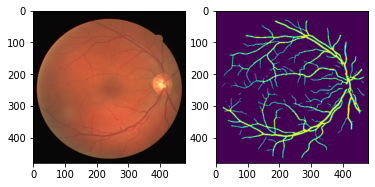

In [35]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)